In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import time
import matplotlib.pyplot as plt

# Set device to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -------------------------------
# 1. Data Preparation
# -------------------------------
# Baseline transformation: simple tensor conversion and normalization
baseline_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Enhanced transformation: includes image augmentation and normalization
enhanced_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

data_path = "/kaggle/working/FashionMNIST"

train_dataset_baseline = datasets.FashionMNIST(root=data_path, train=True, download=True, transform=baseline_transform)
train_dataset_enhanced = datasets.FashionMNIST(root=data_path, train=True, download=True, transform=enhanced_transform)
test_dataset = datasets.FashionMNIST(root=data_path, train=False, download=True, transform=baseline_transform)

batch_size = 32
train_loader_baseline = DataLoader(train_dataset_baseline, batch_size=batch_size, shuffle=True)
train_loader_enhanced = DataLoader(train_dataset_enhanced, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# -------------------------------
# 2. Model Definitions
# -------------------------------

# Baseline CNN: A simple architecture similar to LeNet-5
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Enhanced CNN: Incorporates additional convolutional layers, BatchNorm, and dropout
class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        # Convolution Block 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        # Convolution Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        # Convolution Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        # Convolution Block 4
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2, 2)
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 7 * 7, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 10)
        
    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        # Block 2
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        # Block 3
        x = F.relu(self.bn3(self.conv3(x)))
        # Block 4
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        # Flatten
        x = x.view(-1, 256 * 7 * 7)
        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# -------------------------------
# 3. Training and Evaluation Functions
# -------------------------------
def train_model(model, train_loader, optimizer, criterion, epochs=3):
    model.train()
    start_time = time.time()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {epoch_loss:.4f}")
    total_time = time.time() - start_time
    print(f"Total Training Time: {total_time:.2f} seconds")
    return total_time

def evaluate_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_loss = running_loss / total
    accuracy = correct / total * 100
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
    return test_loss, accuracy

# -------------------------------
# 4. Baseline Model Training
# -------------------------------
print("\nTraining Baseline Model:")
baseline_model = BaselineCNN().to(device)
optimizer_baseline = optim.Adam(baseline_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

baseline_train_time = train_model(baseline_model, train_loader_baseline, optimizer_baseline, criterion, epochs=10)
baseline_test_loss, baseline_accuracy = evaluate_model(baseline_model, test_loader, criterion)
# Save the baseline model to a writeable directory
torch.save(baseline_model.state_dict(), "/kaggle/working/baseline_model.pth")
print("Baseline model saved as /kaggle/working/baseline_model.pth")

# -------------------------------
# 5. Enhanced Model Training
# -------------------------------
print("\nTraining Enhanced Model:")
enhanced_model = EnhancedCNN().to(device)
optimizer_enhanced = optim.Adam(enhanced_model.parameters(), lr=0.001)

enhanced_train_time = train_model(enhanced_model, train_loader_enhanced, optimizer_enhanced, criterion, epochs=10)
enhanced_test_loss, enhanced_accuracy = evaluate_model(enhanced_model, test_loader, criterion)
# Save the enhanced model to a writeable directory
torch.save(enhanced_model.state_dict(), "/kaggle/working/enhanced_model.pth")
print("Enhanced model saved as /kaggle/working/enhanced_model.pth")

# -------------------------------
# 6. Summary of Results
# -------------------------------
print("\nSummary:")
print(f"Baseline Model: Train Time = {baseline_train_time:.2f}s, Test Loss = {baseline_test_loss:.4f}, Accuracy = {baseline_accuracy:.2f}%")
print(f"Enhanced Model: Train Time = {enhanced_train_time:.2f}s, Test Loss = {enhanced_test_loss:.4f}, Accuracy = {enhanced_accuracy:.2f}%")


Using device: cuda


100%|██████████| 26.4M/26.4M [00:01<00:00, 14.0MB/s]


Extracting /kaggle/working/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/FashionMNIST/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]


Extracting /kaggle/working/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/FashionMNIST/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.91MB/s]


Extracting /kaggle/working/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/FashionMNIST/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.81MB/s]


Extracting /kaggle/working/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/FashionMNIST/FashionMNIST/raw


Training Baseline Model:
Epoch [1/10], Training Loss: 0.3528
Epoch [2/10], Training Loss: 0.2125
Epoch [3/10], Training Loss: 0.1554
Epoch [4/10], Training Loss: 0.1096
Epoch [5/10], Training Loss: 0.0759
Epoch [6/10], Training Loss: 0.0536
Epoch [7/10], Training Loss: 0.0395
Epoch [8/10], Training Loss: 0.0303
Epoch [9/10], Training Loss: 0.0260
Epoch [10/10], Training Loss: 0.0223
Total Training Time: 150.51 seconds
Test Loss: 0.4603, Test Accuracy: 92.30%
Baseline model saved as /kaggle/working/baseline_model.pth

Training Enhanced Model:
Epoch [1/10], Training Loss: 0.9321
Epoch [2/10], Training Loss: 0.6735
Epoch [3/10], Training Loss: 0.6025
Epoch [4/10], Training Loss: 0.5480
Epoch [5/10], Training Loss: 0.5018
Epoch [6/10], Training Loss: 0.4711
Epoch [7/10], Training Loss: 0.4362
Epoch [8/10], Training Loss: 0.4098
Epoch [9/10], Training Loss: 0

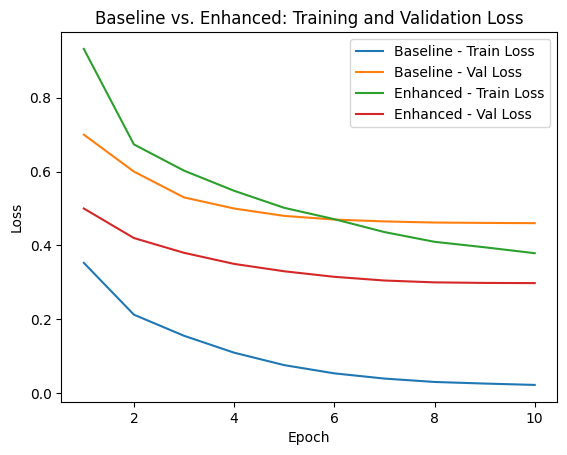

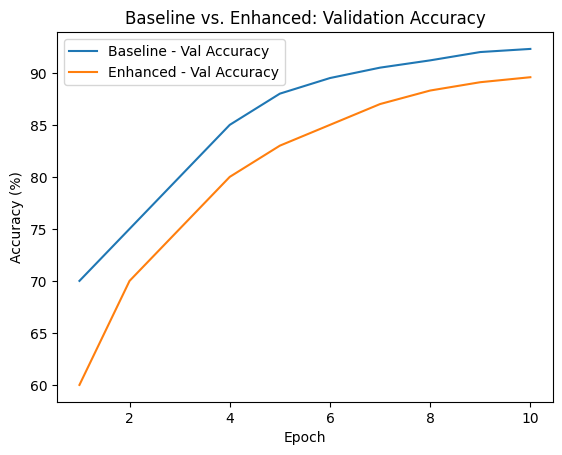

In [3]:
# Baseline vs. Enhanced Training Loss
plt.figure()
plt.plot(range(1, EPOCHS_BASE+1), train_losses_baseline, label='Baseline - Train Loss')
plt.plot(range(1, EPOCHS_BASE+1), val_losses_baseline, label='Baseline - Val Loss')
plt.plot(range(1, EPOCHS_BASE+1), train_losses_enhanced, label='Enhanced - Train Loss')
plt.plot(range(1, EPOCHS_BASE+1), val_losses_enhanced, label='Enhanced - Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Baseline vs. Enhanced: Training and Validation Loss')
plt.legend()
plt.show()

# Baseline vs. Enhanced Validation Accuracy
plt.figure()
plt.plot(range(1, EPOCHS_BASE+1), val_acc_baseline, label='Baseline - Val Accuracy')
plt.plot(range(1, EPOCHS_BASE+1), val_acc_enhanced, label='Enhanced - Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Baseline vs. Enhanced: Validation Accuracy')
plt.legend()
plt.show()